In [19]:
from cgeniepy.ecology import EcoModel
import xarray as xr
import numpy as np
from cgeniepy.array import GriddedData
GriddedData.modify_in_place=False
## plot pft richness maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cmap import Colormap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

arctic_mask = xr.load_dataarray("../data/masked_array.nc")

model = EcoModel("../model/muffin.u067bc.PO4Fe.main/", gemflag=['biogem', 'ecogem'])

time_steps = model.get_pft(1).data.time

## recalculate because foram use a different method
qcarbon_a = model.get_config('ECOGEM')['qcarbon_a']
qcarbon_b = model.get_config('ECOGEM')['qcarbon_b']
volume = model.eco_pars()['volume']
carbon_thresholds = qcarbon_a * volume ** qcarbon_b

## counting from 0
phyto_index = np.arange(0,32)
zoo_index = np.arange(32,64)
mixo_index = np.arange(64,96)
foram_index = np.arange(96,112)
all_index=  [i for i in range(1,113)]

In [20]:
## diversity (no. of PFTs) map

model_mask = model.grid_mask()
pft_n = xr.zeros_like(model.get_pft(1).data) * model_mask
extinction = np.ones(len(carbon_thresholds)) ## 1 means extinct

phyto_rich, zoo_rich, mixo_rich, foram_rich = [], [], [], []

for i in range(len(carbon_thresholds)):
    pft = model.get_pft(i+1)
    threshold = carbon_thresholds[i]    
    ## filter out the species with biomass less than threshold    
    pft_presence = xr.where(pft> threshold, 1, 0.0)
    if i in phyto_index:
        phyto_rich.append(pft_presence)
    elif i in zoo_index:
        zoo_rich.append(pft_presence)
    elif i in mixo_index:
        mixo_rich.append(pft_presence)
    elif i in foram_index:
        foram_rich.append(pft_presence)

    if pft_presence[-1].sum() > 0:
        extinction[i] = 0

## sum over PFT dimension
phyto_rich = xr.concat(phyto_rich, dim='pft') * model_mask* arctic_mask
zoo_rich = xr.concat(zoo_rich, dim='pft') * model_mask* arctic_mask
mixo_rich = xr.concat(mixo_rich, dim='pft')* model_mask* arctic_mask
foram_rich = xr.concat(foram_rich, dim='pft')*model_mask* arctic_mask
total_pft = phyto_rich.sum(dim='pft') + zoo_rich.sum(dim='pft') +mixo_rich.sum(dim='pft') +foram_rich.sum(dim='pft')

total_pft = total_pft *model_mask * arctic_mask
total_pft = GriddedData(total_pft, attrs={'long_name': 'No. PFTs',  'units': ''})
suvivor_rate = (total_pft / total_pft[0]) * 100
suvivor_rate.attrs['long_name'] = 'percentage'

## plot survivors' traits
trait_df=  model.eco_pars().copy()
trait_df['extinction'] = extinction            
survivor_df = trait_df[trait_df['extinction'] == 0]
trait_df['q_C'] = qcarbon_a * trait_df['volume'] ** qcarbon_b

trait_df.to_csv('../output/trait_df.csv', index=False)

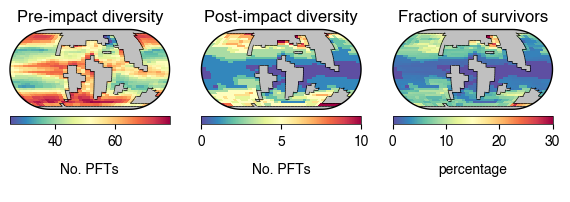

In [21]:
fig, axs = plt.subplots(1,3, subplot_kw={'projection': ccrs.EckertIV()}, figsize=(7,3))
## set font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

cmap="Spectral_r"


total_pft.isel(time=1).plot(ax=axs[0], cmap=cmap, colorbar=True, outline=True, transform=ccrs.PlateCarree())
total_pft.isel(time=-1).plot(ax=axs[1], cmap=cmap, colorbar=True, outline=True,vmax=10)
suvivor_rate.isel(time=-1).plot(ax=axs[2], cmap=cmap, colorbar=True, outline=True, vmin=0, vmax=30)

axs[0].set_title('Pre-impact diversity')
axs[1].set_title('Post-impact diversity')
axs[2].set_title('Fraction of survivors')

fig.savefig('../output/pft_richness.png', dpi=300, bbox_inches='tight')

In [22]:
def count_unique_pfts(data):
    # Sum across spatial dimensions (lat, lon) to get total abundance per PFT per time
    pft_time_sums = data.sum(dim=['lat', 'lon'])
    
    # Create a boolean mask where PFT is present (abundance > 0)
    pft_present = (pft_time_sums > 0)
    
    # Sum the boolean mask along PFT dimension to get count of unique PFTs
    unique_pft_counts = pft_present.sum(dim='pft')
    
    return unique_pft_counts

total_pft_timeseries = count_unique_pfts(phyto_rich) + count_unique_pfts(zoo_rich) + count_unique_pfts(mixo_rich) + count_unique_pfts(foram_rich)
print(total_pft_timeseries)

<xarray.DataArray (time: 18)> Size: 144B
array([99, 99, 99, 99, 99, 24, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22])
Coordinates:
  * time     (time) float64 144B 9.5 49.5 99.5 100.0 ... 120.5 145.5 175.5 199.5


/var/folders/rq/vks10_qx2l9b08d_pygvwfzh0000gn/T/ipykernel_30939/152467974.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(xticks_lbl)


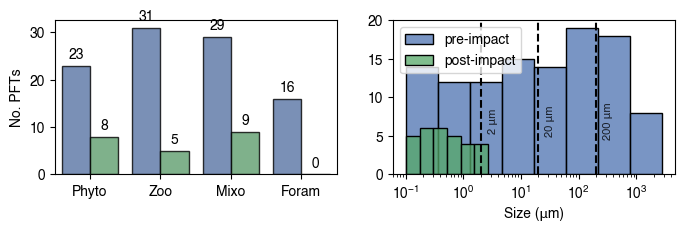

In [32]:
groups = {
    'Phytoplankton': (phyto_rich, count_unique_pfts(phyto_rich)),
    'Zooplankton': (zoo_rich, count_unique_pfts(zoo_rich)),
    'Mixotrophs': (mixo_rich, count_unique_pfts(mixo_rich)),
    'Foraminifera': (foram_rich, count_unique_pfts(foram_rich))
}

# Create DataFrame for plotting
data = []
for group_name, (_, counts) in groups.items():
    data.extend([
        {'Group': group_name, 'Time': 'Pre-impact', 'Count': counts[0].item()},
        {'Group': group_name, 'Time': 'Post-impact', 'Count': counts[-1].item()}
    ])
df = pd.DataFrame(data)
df.to_csv('../data/pft_richness.csv', index=False)

fig, axs = plt.subplots(1,2, figsize=(8, 2))
plt.style.use('seaborn-v0_8-deep')
# Create grouped bar plot
sns.barplot(
    data=df,    
    x='Group',
    y='Count',
    hue='Time',
    ax=axs[0],
    legend=False,
    alpha=0.8,
    edgecolor='black'
    
)

axs[0].set_xlabel('')
axs[0].set_ylabel('No. PFTs')

xticks_lbl = ['Phyto', 'Zoo', 'Mixo', 'Foram']
axs[0].set_xticklabels(xticks_lbl)

# Add value labels on bars
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%.0f', padding=3)


## pre and pst impact size
size_pre = trait_df['diameter']
size_post = survivor_df['diameter']

## seaborn KDe in log scale
plt.style.use('seaborn-v0_8-deep')

axs[1].set_xscale('log')
sns.histplot(size_pre, label='pre-impact', ax=axs[1], kde=False)
sns.histplot(size_post, label='post-impact', ax=axs[1], kde=False)
axs[1].set_xlabel('Size (μm)')
axs[1].set_ylabel('')
axs[1].legend()
## add vertical line for 2, 20, 200 μm
for size in [2, 20, 200]:
    axs[1].axvline(size, color='black', linestyle='--', linewidth=1.5)

## label the vertical lines
## x offset should be same at log scale

x_offsets = [2, 20, 200]
for x_pos in x_offsets:
    label = f'{int(x_pos)} μm'
    axs[1].annotate(label, xy=(x_pos, 7), xytext=(5, 0), 
                   textcoords='offset points', rotation=90, 
                   va='center', ha='left', fontsize=8, color='black',alpha=0.8)
## only integer yticks
yticks = axs[1].get_yticks()
yticks = yticks[yticks == yticks.astype(int)]
axs[1].set_yticks(yticks)

fig.savefig('../output/size_selectivity.pdf', dpi=300, bbox_inches='tight')

In [24]:
# ## size mean of pfts considering only the species that are not extinct
# ## 1) calculate relative biomass for each pft
# total_biomass = model.get_var("eco2D_Plankton_C_Total").data
# pft_rel_data = []
# for i in range(len(carbon_thresholds)):
#     pft = model.get_pft(i+1)
#     pft_rel = pft / total_biomass
#     threshold = carbon_thresholds[i]    
#     pft_rel.data = xr.where(pft> threshold, pft_rel.data, 0.0)
#     ## filter out the species with biomass less than threshold        
#     pft_rel_data.append(pft_rel)    

In [25]:
# ## 2) get size information for each pft
# size = model.eco_pars()['diameter']
# ## zip the size data with the size, multiply the pair and sum the result
# size_mean = xr.zeros_like(pft_rel_data[0].data)

# for i in range(len(pft_rel_data)):
#     size_mean += pft_rel_data[i] * size[i]